## Tabla de Contenidos
1. [**Tutorial:** Ejemplo: Interpolacion polinomial](#Ejemplo:-Interpolacion-polinomial)
2. [**Tutorial:** Ejemplo: problema de Poisson](#Ejemplo:-problema-de-Poisson)
3. [**Tutorial:** Ejemplo: factorizacion LU scipy](#Ejemplo:-factorizacion-LU-scipy) 
4. [**Tutorial:** Ejemplo: solver usando factorizacion LU](#Ejemplo:-Solver-PA-=-LU)
5. [**Tutorial:** Ejemplo: Resolver ecuacion del calor](#Resolver-Ecuacion-del-calor)


In [12]:
import numpy as np
import scipy.linalg as lg
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import splu
# !pip install threadpoolctl==3.2.0
from IPython.display import display, HTML
display(HTML("""<style>.output {display: flex;align-items: center;text-align: center;}</style>"""))

## Ejemplo: Interpolacion polinomial

Considere el problema de encontrar los coeficientes del polinomio cubico que $p(x) = c_1 + c_2x + c_3 x^2 + c_4 x^3$ que interpola los valores $b_1, b_2, b_3, b_4$ en los puntos $x = -1.1, -0.4, 0.2, 0.8$.
Resolvemos generando la matriz de Vandermonde
\begin{equation}
A = \begin{bmatrix}
1 & -1.1 & (-1.1)^{2} & (-1.1)^{3} \\
1 & -0.4 & (-0.4)^{2} & (-0.4)^{3} \\
1 &  0.2 & ( 0.2)^{2} & ( 0.2)^{3} \\
1 &  0.8 & ( 0.8)^{2} & ( 0.8)^{3} 
\end{bmatrix}
\end{equation}

In [13]:
A = np.array([[1 , -1.1 , (-1.1)**2 , (-1.1)**3 ],
              [1 , -0.4 , (-0.4)**2 , (-0.4)**3 ],
              [1 ,  0.2 , ( 0.2)**2 , ( 0.2)**3 ],
              [1 ,  0.8 , ( 0.8)**2 , ( 0.8)**3 ]], dtype=np.float64)
x = np.array([-1.1, -0.4, 0.2, 0.8])

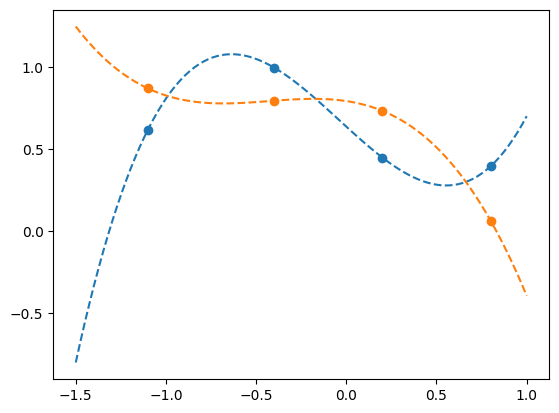

In [15]:
b1 = np.random.rand(4)
b2 = np.random.rand(4)
c1 = np.linalg.solve(A,b1)
c2 = np.linalg.solve(A,b2)

xplot = np.linspace(-1.5, 1, 100)
fig, ax = plt.subplots(1,1)
ax.plot(xplot, np.polyval(c1[::-1], xplot), '--', color='C00')
ax.plot(x, np.polyval(c1[::-1], x), 'o', color='C00')
ax.plot(xplot, np.polyval(c2[::-1], xplot), '--', color='C01')
ax.plot(x, np.polyval(c2[::-1], x), 'o', color='C01')
plt.savefig('polynomialcubic.png')
plt.show()

## Ejemplo: problema de Poisson

Considere la ecuacion diferencial
\begin{equation}
-\Delta u(x) = f(x), \quad\mbox{en }\Omega,\quad u = 0,\quad \mbox{sobre } \partial \Omega
\end{equation}
Caso unidimensional, tenemos la ecuacion
$$ - u''(x) = (4 \pi^2) \sin(2\pi x),\quad u(0) = u(1) = 0$$
cuya solucion es la funcion $u(x) = \sin(2\pi x)$.

Aproximamos usando matrices de diferencias

In [17]:
def Matrizdediferencias(n):
    Dn = np.zeros((n-1,n))
    for i in range(n-1):
        Dn[i,i] = -1.0
        Dn[i,i+1] = 1.0
    return Dn
def uexacta(t):
    return np.sin(2*np.pi*t)

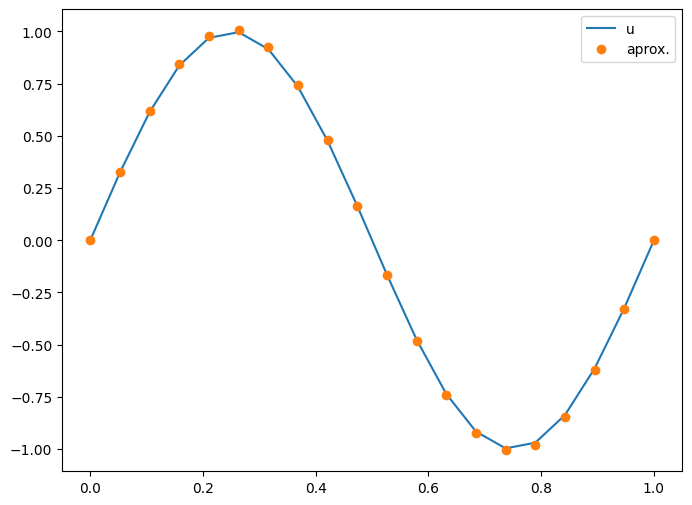

In [20]:
n=20
Dn = Matrizdediferencias(n)
Dnm1 = Matrizdediferencias(n-1)
Delta = Dnm1.dot(Dn)

t = np.array([ i/(n-1) for i in range(n)])
b = np.sin(2*np.pi*t) *(4*np.pi**2)

x = np.zeros(n)
x[0] = 0
x[1:n-1] = -(1/(n-1)**2)*np.linalg.solve(Delta[:,1:n-1], b[1:n-1])
x[-1] = 0
fig, ax = plt.subplots(1,1, figsize=(8,6))
#ax.plot(t, b, 'C03',label='sin(2*pi*x)')

ax.plot(t, uexacta(t), color='C00', label='u')
ax.plot(t, x, 'o', color='C01', label='aprox.')
ax.legend()
plt.show()

## Ejemplo: factorizacion LU scipy
Sea la matriz
\begin{equation}
A = 
\begin{bmatrix}
3 & 17 & 10 \\
2 & 4  &-2  \\
6 & 187 &-12
\end{bmatrix}
\end{equation}


In [29]:
A = np.array([[3,17,10],[2,4,-2],[6,18,-12]], dtype=np.float64)
P,L,U = lg.lu(A)
print(" P:\n", P.T)
print("\n L:\n", L)
print("\n U:\n", U)
print("\n P A - L U:\n", P.T@A - L@U)

 P:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]

 L:
 [[ 1.          0.          0.        ]
 [ 0.5         1.          0.        ]
 [ 0.33333333 -0.25        1.        ]]

 U:
 [[  6.  18. -12.]
 [  0.   8.  16.]
 [  0.   0.   6.]]

 P A - L U:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


## Ejemplo: Solver PA = LU

Algoritmos de sustitucion regresiva y progresiva

In [37]:
def sus_reg(U_input,b_input):
    U = U_input.copy()
    b = b_input.copy()
    n = U.shape[0]
    b[n-1] = b[n-1]/U[n-1,n-1]
    for i in range(n-2,-1,-1):
        b[i] = (b[i] - U[i,(i+1):n].dot(b[(i+1):n]))/U[i,i]
    return b
def sus_prog(L_input,b_input):
    L = L_input.copy()
    b = b_input.copy()
    n = L.shape[0]
    b[0] = b[0]/L[0,0]
    for i in range(1,n):
        b[i] = (b[i] - L[i,0:(i)].dot(b[0:(i)]))/L[i,i]
    return b
def solve_PLU(A, b):
    P,L,U = lg.lu(A)
    y = sus_prog(L,P.T.dot(b))
    x = sus_reg(U,y)
    return x

Los usamos en conjunto con la factorizacion $LU$ para resolver un sistema lineal $Ax = b$ y comparamos las soluciones.

In [38]:
A = np.array([[3,17,10],[2,4,-2],[6,18,-12]], dtype=np.float64)
b = np.array([1.0,1.0,-1.0])
xsol = np.linalg.solve(A, b)
myxsol = solve_PLU(A,b)
print("solucion numpy: \n",xsol)
print("solucion solve_PLU:\n", myxsol)

solucion numpy: 
 [ 1.54861111 -0.38194444  0.28472222]
solucion solve_PLU:
 [ 1.54861111 -0.38194444  0.28472222]


## Resolver Ecuacion del calor

In [16]:
def create_finite_difference_matrix(nx, ny, dx, dy, Q, source_region, T_left):
    """
    Create the finite difference matrix for the steady-state heat equation.
    
    Parameters:
    nx, ny : int
        Number of grid points in x and y directions.
    dx, dy : float
        Grid spacing in x and y directions.
    Q : float
        Heat source term.
    source_region : tuple
        (y_start, y_end) defining the region where the heat source is applied.
    T_left : float
        Temperature on the left boundary in the source region.
        
    Returns:
    A : scipy.sparse.csc_matrix
        The system matrix in CSC format.
    b : numpy.ndarray
        The right-hand side vector.
    """
    n = nx * ny
    A = lil_matrix((n, n))
    b = np.zeros(n)
    
    # Map 2D index to 1D index
    def index(i, j):
        return i + j * nx
    
    # Boundary conditions for the heat source on the left boundary
    y_start_idx = int(source_region[0] / dy)
    y_end_idx = int(source_region[1] / dy)
    
    for j in range(ny):
        for i in range(nx):
            idx = index(i, j)
            if i == 0:
                if y_start_idx <= j <= y_end_idx:
                    A[idx, idx] = 1
                    b[idx] = T_left
                else:
                    A[idx, idx] = 1
                    b[idx] = 0
            elif i == nx - 1:
                A[idx, idx] = 1
                b[idx] = 0
            elif j == 0:
                # Neumann BC at bottom (y = 0): T(i, 0) - T(i, 1) = 0
                A[idx, idx] = -1
                A[idx, index(i, j + 1)] = 1
                b[idx] = 0
            elif j == ny - 1:
                # Neumann BC at top (y = Ly): T(i, ny-1) - T(i, ny-2) = 0
                A[idx, idx] = -1
                A[idx, index(i, j - 1)] = 1
                b[idx] = 0
            else:
                A[idx, index(i - 1, j)] = 1 / dx**2
                A[idx, index(i + 1, j)] = 1 / dx**2
                A[idx, index(i, j - 1)] = 1 / dy**2
                A[idx, index(i, j + 1)] = 1 / dy**2
                A[idx, idx] = -2 / dx**2 - 2 / dy**2
                b[idx] = -Q
    
    return A.tocsc(), b

In [17]:
# Problem parameters
nx, ny = 500, 500  # Number of grid points
Lx, Ly = 3.0, 1.0  # Dimensions of the domain
dx, dy = Lx / (nx - 1), Ly / (ny - 1)
T_left = 100.0  # Temperature on the left boundary in the source region
Q = 0.0  # Heat source term
source_region = (0.25, 0.75)  # y-range of the heat source on the left boundary



In [18]:
def solve_heat_equation(nx, ny, dx, dy, T_left, Q, source_region):
    A, b = create_finite_difference_matrix(nx, ny, dx, dy, Q, source_region, T_left)
    plt.spy(A)
    plt.show()
    lu = splu(A)
    T_flat = lu.solve(b)
    T = T_flat.reshape((ny, nx))
    return T

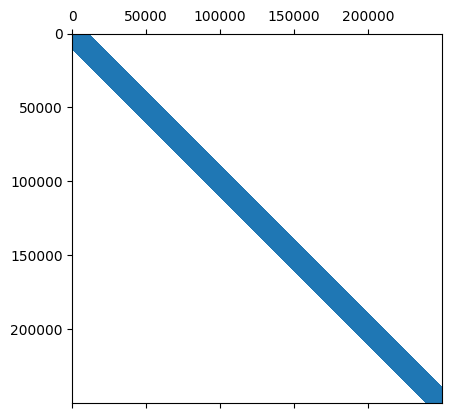

In [19]:

# Solve the heat equation
T = solve_heat_equation(nx, ny, dx, dy, T_left, Q, source_region)


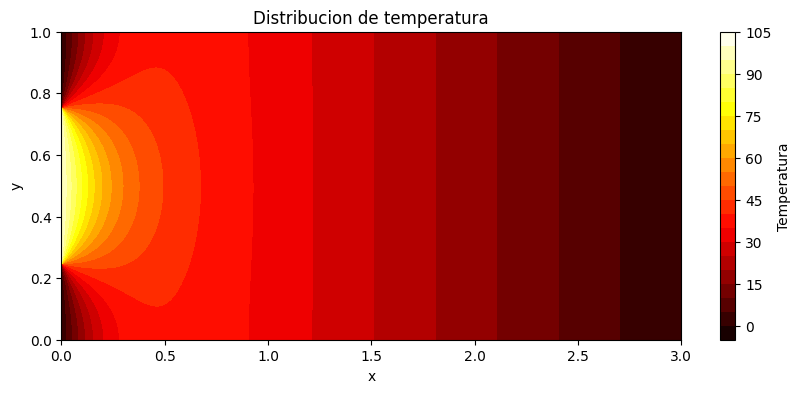

In [11]:

# Plot the results
X, Y = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(0, Ly, ny))
fig, ax = plt.subplots(1,1,figsize=(10,4))
im = ax.contourf(X, Y, T, 20, cmap='hot')
fig.colorbar(im, label='Temperatura')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Distribucion de temperatura')
plt.show()